<a href="https://colab.research.google.com/github/Chubbyman2/Udacity_Tensorflow_Tutorials/blob/master/Transfer_Learning_Cats_%26_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

import matplotlib.pylab as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

**Download the Classifier**

In [ ]:
# MobileNet expects images of 224x224 pixels, in 3 RGB colour channels
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

**Test on an Image**

MobileNet has 1001 different output classes, one is military uniforms. 

We'll show it a military uniform, and see if it predicts it accurately.

65536/61306 [================================] - 0s 0us/step


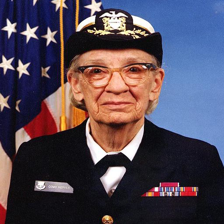

In [ ]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES, IMAGE_RES))
grace_hopper 

In [ ]:
# Change pixels to 0-1 range
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [ ]:
# Give the image a batch dimension, since models always need batches
# .predict always expects a batch dimension
result = model.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [ ]:
# Out of the 1001 classes, this returns the most likely class index
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

**Finding the Actual Class Name**

16384/10484 [==============================================] - 0s 0us/step


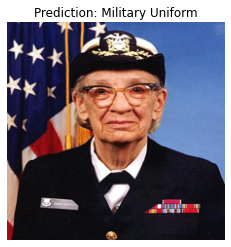

In [ ]:
# And so it accurately predicted "military uniform"
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis("off")
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

**Using it for Cats and Dogs**

In [ ]:
# Load Dataset
(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs', 
    with_info=True, 
    as_supervised=True, 
    split=['train[:80%]', 'train[80%:]'],
)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteLFZBSC/cats_vs_dogs-train.tfrecord



Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [ ]:
# Reformat image sizes, since they're not all 224x224
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

**Run the Classifier on a Batch of Images**

Since ImageNet has a lot of classes and is trained on lots of images (including cats and dogs), see if it can predict the images in our dogs + cats dataset.

In [ ]:
# Displays the list of classes based on our dataset
# Derived from MobileNet's training from ImageNet
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['Chesapeake Bay retriever', 'toy terrier', 'Scottish deerhound',
       'flat-coated retriever', 'tabby', 'white wolf', 'Egyptian cat',
       'redbone', 'Egyptian cat', 'Egyptian cat', 'cocker spaniel',
       'Egyptian cat', 'hamster', 'Egyptian cat',
       'American Staffordshire terrier', 'Tibetan mastiff', 'tiger cat',
       'tabby', 'American Staffordshire terrier', 'tabby', 'Egyptian cat',
       'German short-haired pointer', 'toy poodle', 'tiger cat', 'dingo',
       'gibbon', 'tabby', 'redbone', 'tabby', 'Saint Bernard', 'tabby',
       'muzzle'], dtype='<U30')

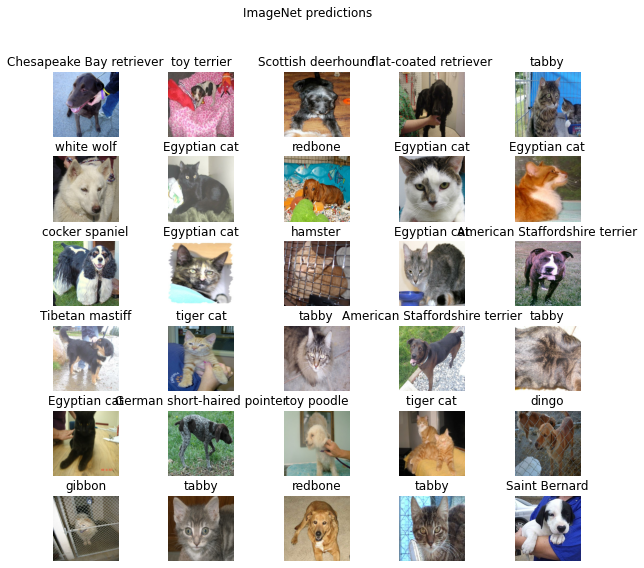

In [ ]:
# Since MobileNet was trained on so many, it can put labels beside each of the images in our dataset
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

The partial model without the final classification layer is known as a **feature_extractor**.

Basically, the feature_extractor has already taken the inputs  and processed them all the way to the final output layer.

That is, it has extracted the features of the image.

Note:

1. There are 32 images in the batch.

2. There are 1280 neurons in the last layer of the partial model.

In [ ]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

In [ ]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


**Create the Model**

In [ ]:
# Freeze the variables in the feature_extractor for training the classifier layer
feature_extractor.trainable = False

model = tf.keras.Sequential([
    feature_extractor,
    layers.Dense(2)
])

model.summary

<bound method Network.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f8a0b19dbe0>>

**Train the Model**

OMG - 99.43% accuracy and 98.86% val_accuracy

In [ ]:
# Compile, then fit

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

EPOCHS = 6
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
582/582 [==============================] - 59s 102ms/step - loss: 0.0542 - accuracy: 0.9813 - val_loss: 0.0320 - val_accuracy: 0.9888
Epoch 2/6
582/582 [==============================] - 58s 100ms/step - loss: 0.0304 - accuracy: 0.9902 - val_loss: 0.0316 - val_accuracy: 0.9890
Epoch 3/6
582/582 [==============================] - 58s 100ms/step - loss: 0.0255 - accuracy: 0.9913 - val_loss: 0.0314 - val_accuracy: 0.9903
Epoch 4/6
582/582 [==============================] - 58s 100ms/step - loss: 0.0210 - accuracy: 0.9936 - val_loss: 0.0312 - val_accuracy: 0.9901
Epoch 5/6
582/582 [==============================] - 58s 100ms/step - loss: 0.0192 - accuracy: 0.9935 - val_loss: 0.0353 - val_accuracy: 0.9873
Epoch 6/6
582/582 [==============================] - 58s 100ms/step - loss: 0.0175 - accuracy: 0.9943 - val_loss: 0.0351 - val_accuracy: 0.9886


**Plot Training and Validation Accuracy/Loss**

If the validation performance is consistently better than the training performance:

Biggest reason would be that the network performs image augmentation on the training images while training.

However, the validation dataset is not augmented, making it easier to classify.

Nevertheless, everything seems to have gone according to plan in this case.

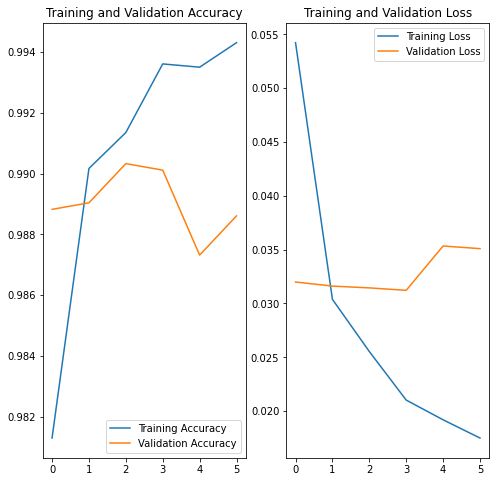

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Check the Predictions**

Just some code to see how well the model performs.

Labels:  [1 1 1 1 0 1 0 1 0 0 1 0 0 0 1 1 0 0 1 0 0 1 1 0 1 1 0 1 0 1 0 0]
Predicted labels:  [1 1 1 1 0 1 0 1 0 0 1 0 0 0 1 1 0 0 1 0 0 1 1 0 1 1 0 1 0 1 0 0]


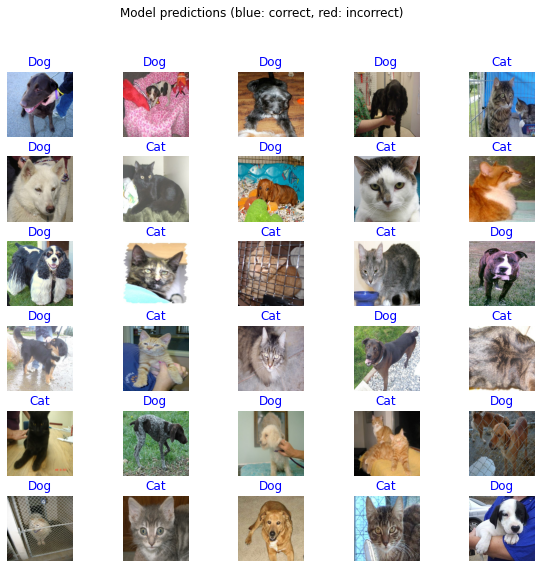

In [ ]:
# Get ordered list of class names
class_names = np.array(info.features['label'].names)
class_names

# Runs image batch through model
# Converts indices to class names
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names


# Checks true labels and predicted ones
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")